In [1]:
import numpy as np
#import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib inline
rng = np.random.RandomState(42)

In [2]:
fig_dir = r"C:\Users\Fabusuyi\Documents\Work _UCT\PG\Write_Up\figs\misc"
data_dir = os.path.normpath(r"C:\Users\Fabusuyi\Documents\Work _UCT\PG\thesis-code\matlab_code\multisine")

def save_figure(fname, obj, dir=fig_dir):
    """wrapper to save figure in desied directory"""
    path = os.path.join(os.path.normpath(fig_dir), fname)
    obj.savefig(path, bbox_inches='tight')

def draw_multisine(freqs,  period, sampling_freq, phases=None, amp=0.1, 
                    n_period=1.0):
    """draws yields time vector and corresponding y value for a
    multisine using the given parameters"""
    
    if phases is None:
        phases = np.zeros([1, len(freqs)])
        
    if not isinstance(amp, list):
        amp = np.repeat(amp, len(freqs))
    
#     freqs = np.array(freqs)
#     freqs = freqs[:, None]

    amp = np.array(amp)
    amp = np.diag(amp)
    phases = np.array(phases)
    phases = phases[:len(freqs)]

    freqs = np.matrix(freqs)
    phases = np.matrix(phases)
        
    t = np.arange(0, n_period*period, 1/sampling_freq)
    t = np.matrix(t)
    y = np.sum(amp * np.sin(2 * np.pi * freqs.T * t + phases[0:len(freqs)+1].T), 0)
    
    t = np.asarray(t).reshape(-1)
    y = np.asarray(y).reshape(-1)
    return (t, y)

def dft_map(x, Fs):
    """sort of a wrapper arrount the FFT method to 
    map the signal clock"""
    
    X = np.fft.fft(x)
    #X = np.fft.fftshift(x)
    N = np.float64(len(x))
    freqs = Fs * np.arange(0, N/2 + 1) / N
    
    X_mag = abs(X / N)
    X_ph = np.angle(X, deg=1)
    
    X_mag = X_mag[np.arange(0, N/2+1, dtype=int)]
    X_mag[1:-1] = 2 * X_mag[1:-1]
    
    X_ph = X_ph[np.arange(0, N/2+1, dtype=int)]
    
    thresh = np.max(X_mag) / 10000  # solves the phase numerical precision problem
    X_ph[X_mag < thresh] = 0
    
    return freqs, X_mag, X_ph

def non_lin_sys(sig_input, rms_noise=0.1, poly_coeff=[25e-3, 1, 3e-1, -1e-3, 5e-6, 1e-5]):
    """weakly non-linear system takes in sig_input signal
    and returns an output signal"""
    

    order = len(poly_coeff) - 1  # minus DC point
    sig_input_length = len(sig_input)
    
    noise_sig_input = rms_noise * rng.normal(loc=0, scale=1, size=sig_input_length)
    noisy_sig_input = sig_input + noise_sig_input
    
    #poly_coeff.reverse()  # very problematic
    output = np.polyval(poly_coeff[::-1], noisy_sig_input)
    
    return output

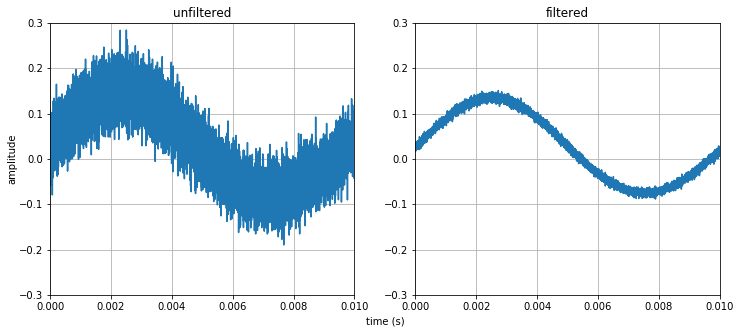

In [3]:
fs=1000000
t, y = draw_multisine([85, 100, 125, 50000, 200000], 3, fs, amp=[0.01, 0.09, 0.02, 0.03, 0.007])
t_, y_ = draw_multisine([85, 100, 125, 5000], 3, fs, amp=[0.01, 0.095, 0.002, 0.001])
output = non_lin_sys(y, rms_noise=0.03)
output_ = non_lin_sys(y_, rms_noise=0.005)
fig, ax = plt.subplots(1,2, figsize=(12, 5))
ax0 = ax[0]
ax1 = ax[1]

ax0.plot(t, output)
ax1.plot(t_, output_)

ax0.set_title('unfiltered')
ax1.set_title('filtered')
for ax in ax:
    ax.set_xlim(0, 0.01)
    ax.set_ylim(-0.3, 0.3);
    ax.grid('on', )


fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top='off', 
                bottom='off', left='off', right='off')
plt.xlabel("time (s)")
plt.ylabel('amplitude', labelpad=10);

save_figure('filtering_signal.png', fig)

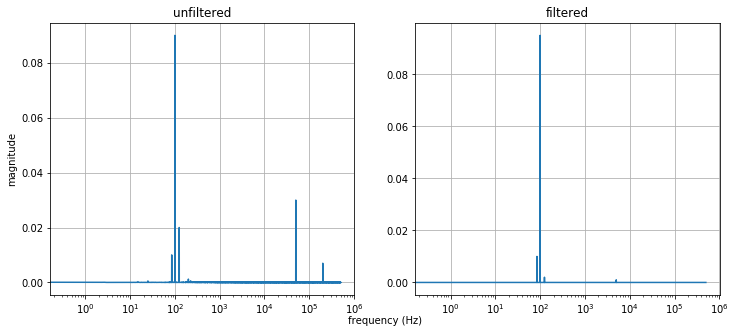

In [7]:
freqs, X_mag, X_ph = dft_map(x=output, Fs=fs);
freqs_, X_mag_, X_ph_ = dft_map(x=y_, Fs=fs);

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
ax0 = axs[0]
ax1 = axs[1]

for ax in axs:

    ax.grid('on')

ax0.semilogx(freqs, X_mag)
ax1.semilogx(freqs_, X_mag_)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top='off', 
                bottom='off', left='off', right='off')
plt.xlabel("frequency (Hz)")
plt.ylabel('magnitude', labelpad=10);

ax0.set_title('unfiltered')
ax1.set_title('filtered')

save_figure('filtering_spectrum.png', fig)